In [11]:
from stable_baselines3 import PPO
from ot2_gym_wrapper import OT2Env 
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
from pipeline import landmarks

In [3]:
# instantiate your custom environment
env = OT2Env(render='human') 

The goal position is: [0.252872   0.12895665 0.14112025]


In [5]:
# Obtaining the image in the plate
image_path = env.get_plate_image()

In [17]:
# Applying landmark detection for the primary root tip
coordinates = landmarks(image_path)


Top padding is 6
Bottom padding is 6
Left padding is 6
Right padding is 6

4/4 [==============================] - 3s 810ms/step


In [7]:
#Creating Conversion factor
plate_size_m = 0.15

plate_size_pixels = 2804

conversion_factor = plate_size_m / plate_size_pixels

goal_positions = []

In [8]:
# Empty list to hold adjusted coordinates
goal_positions = []

# Additional offset or adjustment for each axis
offset_x = 0.10775
offset_y = 0.088

# Loop through each dictionary in the coordinates list
for coord in coordinates:
    # Extract the primary_root_tip tuple
    original_position = coord["primary_root_tip"]
    # Adjust the tuple values by multiplying with the conversion factor and round the results
    adjusted_position = (original_position[1] * conversion_factor, original_position[0] * conversion_factor)
    # Append the adjusted coordinate tuple to the goal_positions list
    goal_positions.append(adjusted_position)

# Print the resulting list of adjusted positions
print(goal_positions)

[(0.07623038516405135, 0.025677603423680456), (0.06312410841654778, 0.04937589158345221), (0.06269614835948645, 0.07639087018544935), (0.06130527817403709, 0.1019079885877318), (0.06398002853067046, 0.131972182596291)]


In [9]:
# Load the trained agent
model = PPO.load('RL_models_2/rl_model_9')


Plant 1
Goal position is: (0.19798038516405136, 0.11367760342368045, 0.1695)
complete with an error of 
0.008990738540887833 in 4.37 seconds and 278 iterations


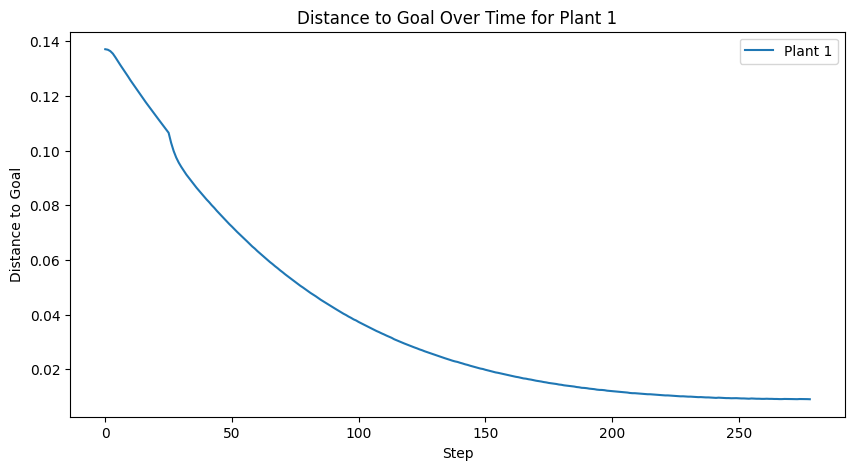


Plant 2
Goal position is: (0.18487410841654778, 0.1373758915834522, 0.1695)
complete with an error of 
0.008954193443059921 in 1.63 seconds and 102 iterations


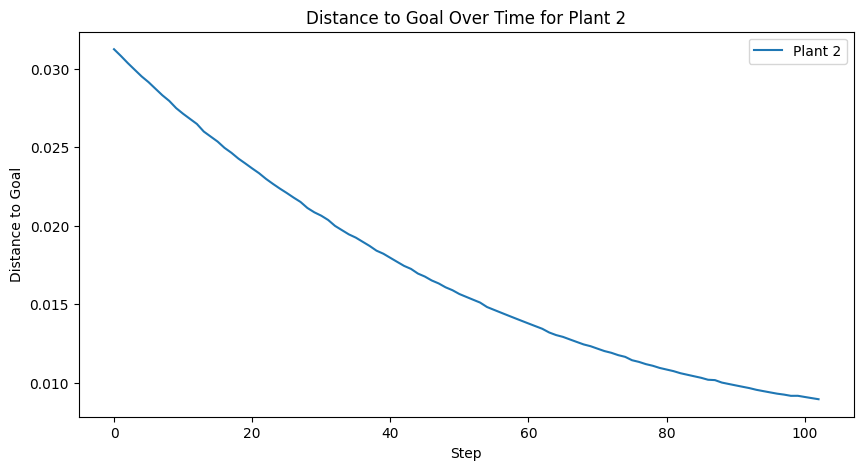


Plant 3
Goal position is: (0.18444614835948647, 0.16439087018544934, 0.1695)
complete with an error of 
0.008951657451689243 in 1.28 seconds and 80 iterations


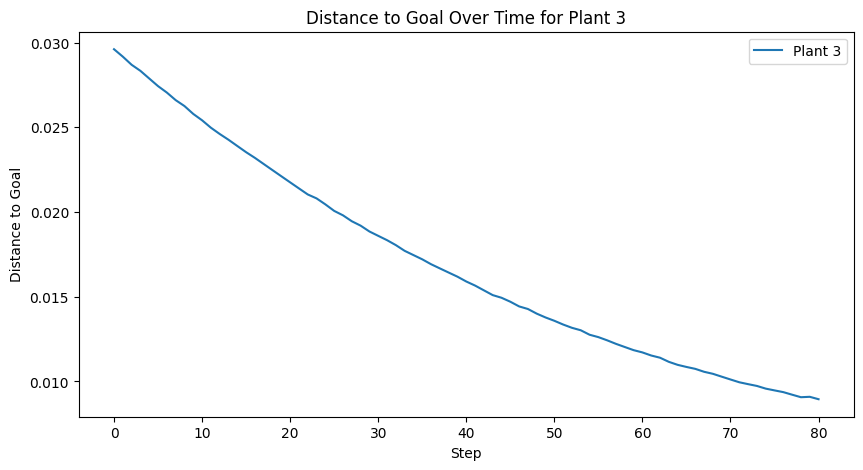


Plant 4
Goal position is: (0.1830552781740371, 0.18990798858773178, 0.1695)
complete with an error of 
0.00894705019891262 in 1.12 seconds and 70 iterations


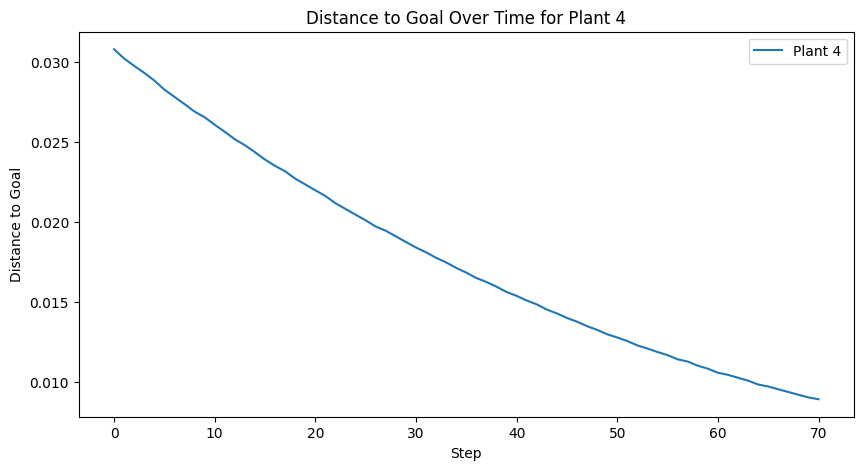


Plant 5
Goal position is: (0.18573002853067047, 0.219972182596291, 0.1695)
complete with an error of 
0.008955972269177437 in 1.09 seconds and 68 iterations


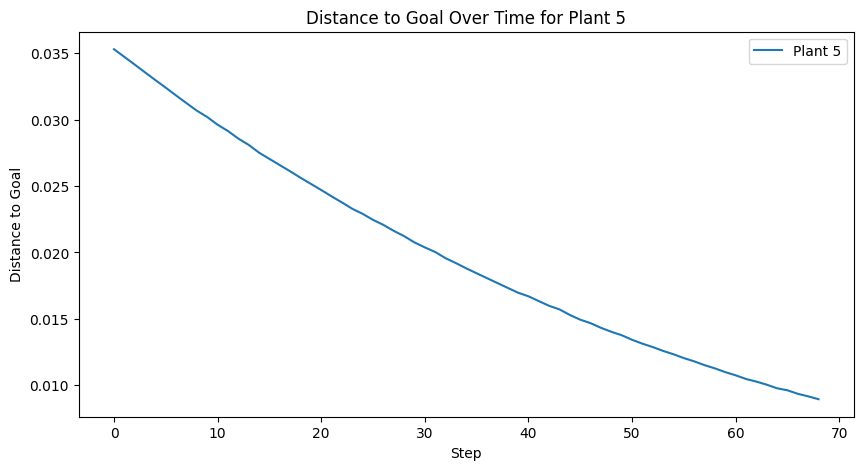

In [16]:
# Resetting the environment
obs, info = env.reset()

x_adjustment = 0.014
y_adjustment = 0


# Add a counter for the goal positions
for index, goal_pos in enumerate(goal_positions, start=1):  # Start=1 to begin counting from 1

    # Initialize a list to store distances for plotting
    distances = []

    # Set the goal position for the robot
    goal_pos_x = 0.10775 + goal_pos[0] + x_adjustment
    goal_pos_y = 0.088 + goal_pos[1] + y_adjustment
    goal_pos_z = 0.1695
    goal_pos = np.array([goal_pos_x, goal_pos_y, goal_pos_z])
    env.goal_position = goal_pos
    
    # Modify the print statement to include the goal position number
    print(f'\nPlant {index}')  # Use the counter here
    print(f'Goal position is: {goal_pos_x, goal_pos_y, goal_pos_z}')

    start_time = time.time()
       
    # Run the control algorithm until the robot reaches the goal position
    for i in range(100000):
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, terminated, truncated, info = env.step(action)
        
        # calculate the distance between the pipette and the goal
        distance = obs[3:] - obs[:3]  # goal position - pipette position
        error = np.linalg.norm(distance)
        
        # Store the error for plotting
        distances.append(error)
        
        # Drop the inoculum if the robot is within the required error
        if error < 0.009:
            action = np.array([0, 0, 0, 1])
            obs, rewards, terminated, truncated, info = env.step(action)
            end_time = time.time()  # Stop the timer
            elapsed_time = end_time - start_time  # Calculate the elapsed time
            print(f'complete with an error of \n{error} in {elapsed_time:.2f} seconds and {i} iterations')
            break

        if terminated:
            print('Episode terminated')
            obs, info = env.reset()
            print('Environment reset')
            break

    # After the loop, plot the distances for the current goal position
    plt.figure(figsize=(10, 5))
    plt.plot(distances, label=f'Plant {index}')
    plt.xlabel('Step')
    plt.ylabel('Distance to Goal')
    plt.title(f'Distance to Goal Over Time for Plant {index}')
    plt.legend()
    plt.show()
